In [1]:
## Loading Libraries and Modules

# scikit-learn: barebones, but fast and reliable
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error, r2_score, mean_squared_error, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import VotingClassifier, BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# statsmodels: pretty and good to use, great for interpretable ML
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data processing
import pandas as pd
import numpy as np

# Plotting things:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

First I am importing the QOG dataset with the variables I need, and renaming them.

In [2]:
q = pd.read_csv('https://www.qogdata.pol.gu.se/data/qog_std_ts_jan24.csv')
q = q[q['year'] == 2015]
q.head()

q.rename(columns={
    'cname': 'Country',
    'wdi_expedu': 'Education_Expenditure',
    'wdi_chexppgdp': 'Healthcare_Expenditure',
    'wdi_gdpcapcur': 'GDP',
    'gii_gii': 'Gender_Inequality_Index',
    'wdi_unempfilo': 'Unemployment Rate F',
    'undp_hdi': 'HDI',
    'cai_cai1': 'Comparative_Abortion_Index',


}, inplace=True)

q = q[['Country', 'GDP', 'HDI','Education_Expenditure', 'Healthcare_Expenditure', 
       'Comparative_Abortion_Index',
      ]]
q.head(15)

/tmp/ipykernel_1908/1156272983.py:1: DtypeWarning: Columns (818,822,826,830,1318,1319) have mixed types. Specify dtype option on import or set low_memory=False.
  q = pd.read_csv('https://www.qogdata.pol.gu.se/data/qog_std_ts_jan24.csv')


,Country,GDP,HDI,Education_Expenditure,Healthcare_Expenditure,Comparative_Abortion_Index
69,Afghanistan,592.476165,0.478,3.255800,10.105348,1.0
147,Albania,3952.803584,0.795,3.437970,6.483612,7.0
225,Algeria,4197.419971,0.740,7.962967,6.978492,3.0
303,Andorra,38885.530324,0.867,3.280350,7.023242,1.0
381,Angola,3100.830685,0.582,3.100000,2.605795,1.0
459,Antigua and Barbuda,14861.882707,0.791,2.655929,5.279655,1.0
537,Azerbaijan,5500.504620,0.748,2.951680,4.106636,7.0
615,Argentina,13789.060425,0.848,5.776110,10.229337,3.0
693,Australia,56708.961197,0.933,5.315520,10.183613,7.0
771,Austria,44195.817595,0.910,5.456580,10.367467,7.0


Now I am adding a new column with the log values of all the variables to help linearize the data. Then I standardized the data so that my analysis is comparable across variables.

In [3]:
#Add column of log variables

# List of columns to transform
columns_to_log = ['GDP', 'HDI', 'Education_Expenditure', 
                   'Healthcare_Expenditure', 'Comparative_Abortion_Index', 
                   ]

# Add log-transformed columns to the dataset
for column in columns_to_log:
    # Handle potential zero or negative values
    q[f'log_{column}'] = np.log1p(q[column])  # Using np.log1p to handle zero values

# Standardize the data
scaler = StandardScaler()
columns_to_standardize = columns_to_log + [f'log_{col}' for col in columns_to_log]
q_standardized = q.copy()  # Create a copy to avoid modifying the original dataframe
q_standardized[columns_to_standardize] = scaler.fit_transform(q_standardized[columns_to_standardize])

# Now 'q_standardized' contains the standardized version of the original and log-transformed variables
q_standardized.head()

,Country,GDP,HDI,Education_Expenditure,Healthcare_Expenditure,Comparative_Abortion_Index,log_GDP,log_HDI,log_Education_Expenditure,log_Healthcare_Expenditure,log_Comparative_Abortion_Index
69,Afghanistan,-0.583986,-1.539558,-0.704928,1.252434,-1.270023,-1.578428,-1.576478,-0.700542,1.253102,-1.348789
147,Albania,-0.442356,0.554269,-0.604952,-0.013052,1.197205,-0.244017,0.574509,-0.564223,0.169914,1.029684
225,Algeria,-0.432046,0.190987,1.878399,0.159866,-0.447613,-0.201778,0.230025,1.721868,0.345639,-0.159553
303,Andorra,1.029973,1.029838,-0.691454,0.175503,-1.270023,1.364485,1.009851,-0.681835,0.360988,-1.348789
381,Angola,-0.478265,-0.852624,-0.790432,-1.368016,-1.270023,-0.414781,-0.823746,-0.821841,-1.833866,-1.348789


Here I am importing my maternal mortality dataset from kaggle and making a column for log MMR.

In [4]:
m = pd.read_csv('Maternal Mortality.csv')
m = m[['Country', 'Continent', 'Maternal Mortality Ratio (deaths per 100,000 live births) (2015)']]
m.rename(columns={
    'Maternal Mortality Ratio (deaths per 100,000 live births) (2015)': 'MMR'
}, inplace=True)

m['log_MMR'] = np.log(m['MMR'])

m.head()

,Country,Continent,MMR,log_MMR
0,Afghanistan,Asia,701.0,6.552508
1,Angola,Africa,251.0,5.525453
2,Albania,Europe,15.0,2.708050
3,Andorra,Europe,NaN,NaN
4,United Arab Emirates,Asia,3.0,1.098612


To start, I am making a barplot showing the overall MMR rates by continent.

/tmp/ipykernel_1908/2994715793.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=m, x='MMR', y='Continent', palette=sns.color_palette("twilight"))
/tmp/ipykernel_1908/2994715793.py:5: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.barplot(data=m, x='MMR', y='Continent', palette=sns.color_palette("twilight"))


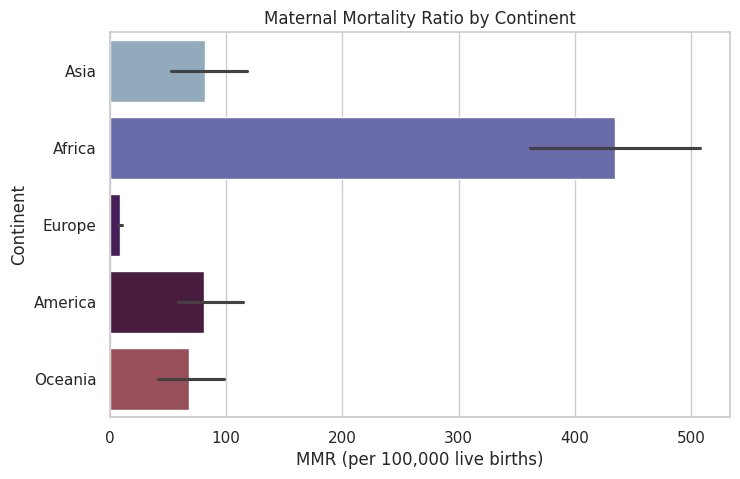

In [5]:
sns.set_theme(style="whitegrid")

# Create a bar plot using the muted palette
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=m, x='MMR', y='Continent', palette=sns.color_palette("twilight"))

# Adjust the title and labels
plt.title('Maternal Mortality Ratio by Continent')
plt.xlabel('MMR (per 100,000 live births)')
plt.ylabel('Continent')

plt.show()

Now I am merging my two tables, the data from QOG and from Kaggle.

In [6]:
#merging all the data

merged = pd.merge(m, q_standardized, on='Country', how='inner')
merged = merged.dropna()

merged.head()

,Country,Continent,MMR,log_MMR,GDP,HDI,Education_Expenditure,Healthcare_Expenditure,Comparative_Abortion_Index,log_GDP,log_HDI,log_Education_Expenditure,log_Healthcare_Expenditure,log_Comparative_Abortion_Index
0,Afghanistan,Asia,701.0,6.552508,-0.583986,-1.539558,-0.704928,1.252434,-1.270023,-1.578428,-1.576478,-0.700542,1.253102,-1.348789
1,Angola,Africa,251.0,5.525453,-0.478265,-0.852624,-0.790432,-1.368016,-1.270023,-0.414781,-0.823746,-0.821841,-1.833866,-1.348789
2,Albania,Europe,15.0,2.708050,-0.442356,0.554269,-0.604952,-0.013052,1.197205,-0.244017,0.574509,-0.564223,0.169914,1.029684
4,Argentina,America,41.0,3.713572,-0.027782,0.904341,0.678236,1.295758,-0.447613,0.635021,0.896622,0.812192,1.283571,-0.159553
5,Armenia,Asia,28.0,3.332205,-0.454439,0.362720,-0.951830,1.256725,1.197205,-0.296977,0.394208,-1.063920,1.256134,1.029684


Before starting the analysis I am performing a multicollinearity check to make sure that none of the variables have too large of an impact on another.

In [7]:
#checking multicollinearity

variables = merged[['GDP', 'HDI', 'Education_Expenditure', 'Healthcare_Expenditure', 
            'Comparative_Abortion_Index', ]]
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

[1.9992657524070578,
 2.2515269372697504,
 1.174606437637235,
 1.3008473675932313,
 1.2991436965786065]

they are all under 5 so we are good!

Here I created a heatmap to get a visual idea of the multicollinearity between the variables.

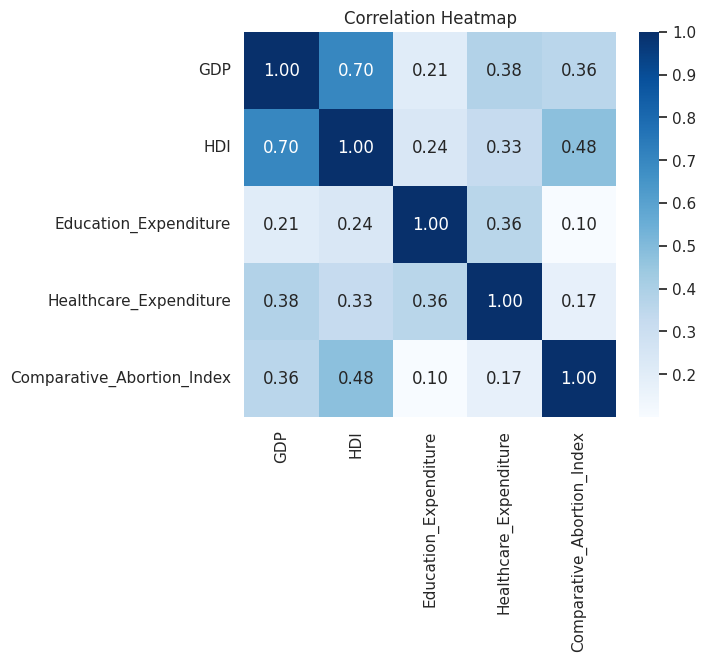

In [8]:
#making a heatmap to show multicollinearity

correlation_matrix = variables.corr()

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Here I am plotting linear regressions for each variable independently. Later I will plot them all together and we can observe how the relationship between independent and dependent variables change when considering all indepedent variables together.

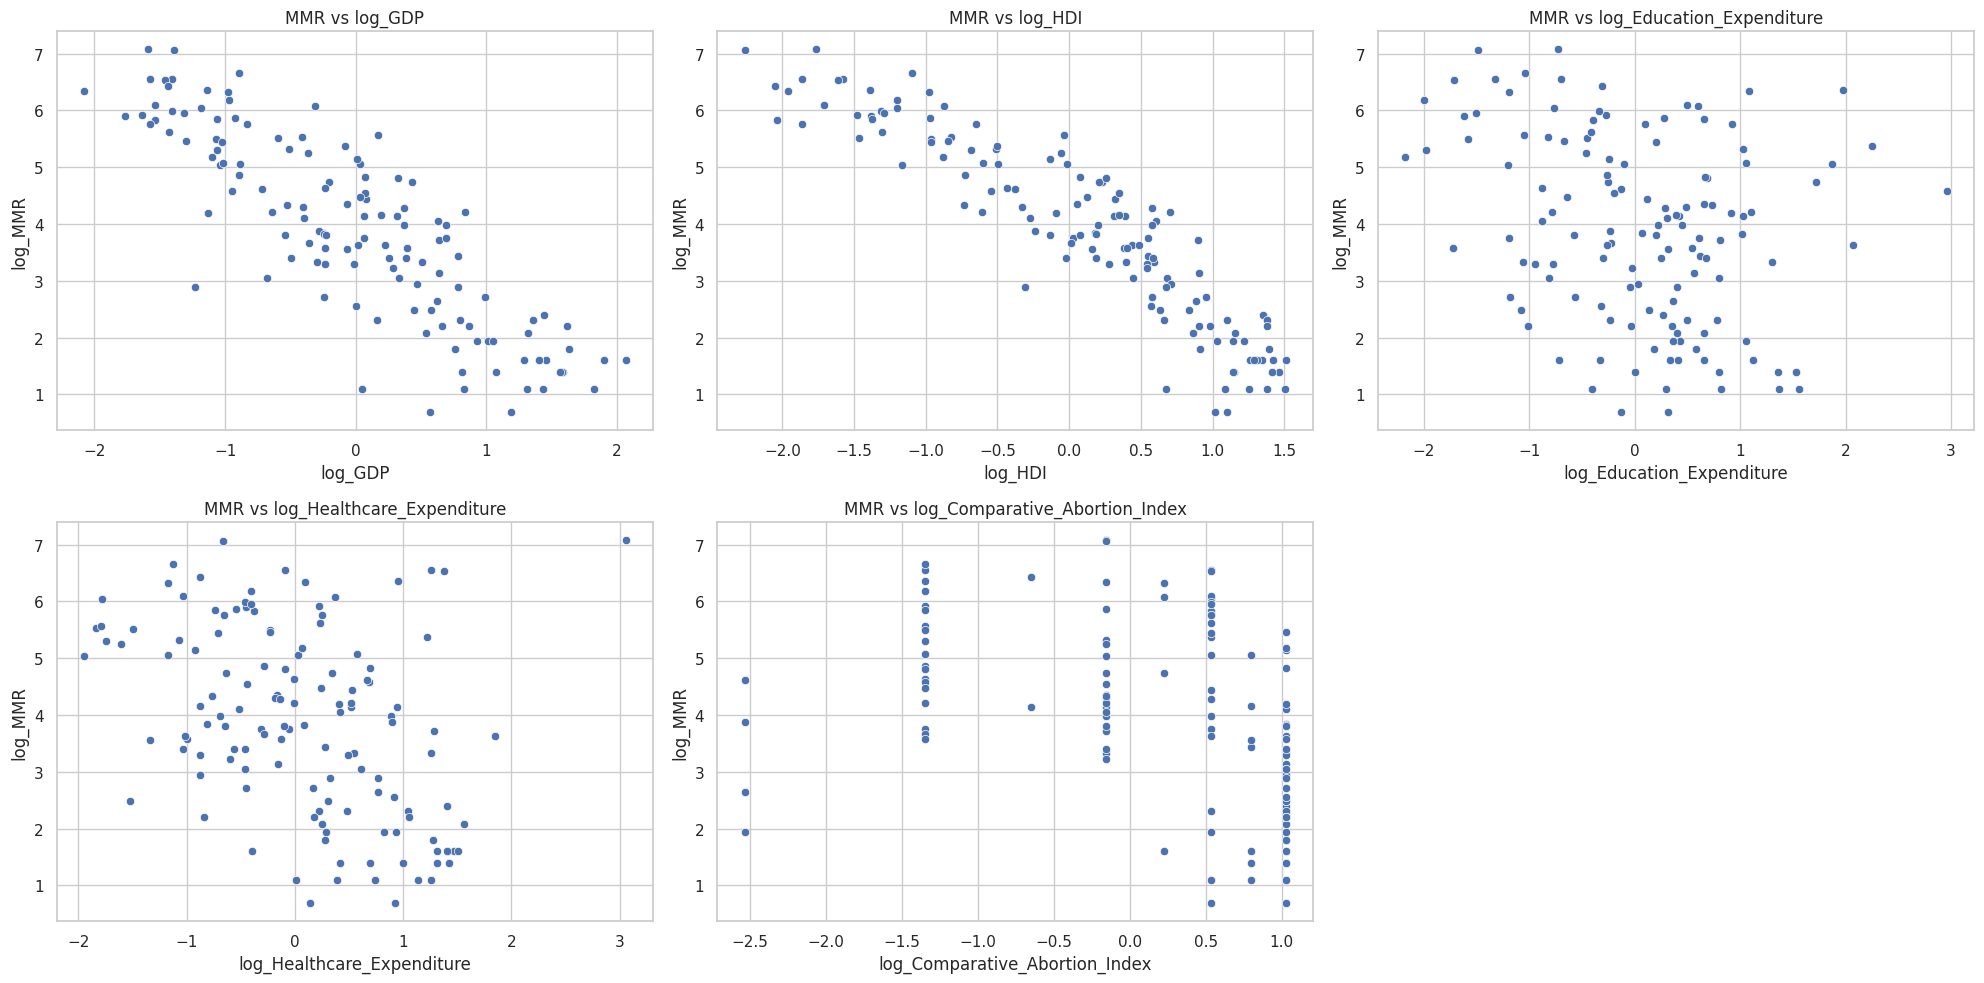

In [42]:
# Creating regression plots for the variables
# List of variables to plot against 'MMR'
variables = ['log_GDP', 'log_HDI', 'log_Education_Expenditure', 'log_Healthcare_Expenditure', 
             'log_Comparative_Abortion_Index', 
             ]

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each variable in the grid
for i, var in enumerate(variables):
    sns.scatterplot(x=var, y='log_MMR', data=merged, ax=axes[i])
    axes[i].set_title(f'MMR vs {var}')

# Remove the last empty subplot if there are fewer than 8 plots
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


For my analysis I am running an OLS regression.

In [74]:
xx = merged[['log_GDP', 'log_HDI', 'log_Education_Expenditure', 
             'log_Healthcare_Expenditure', 'log_Comparative_Abortion_Index']]

# Define the dependent variable (target)
yy = merged['log_MMR']

# Add a constant to the model (intercept)
xx = sm.add_constant(xx) 

# Fit the OLS model
model = sm.OLS(yy, xx).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_MMR   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     149.5
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.25e-51
Time:                        18:41:22   Log-Likelihood:                -125.19
No. Observations:                 132   AIC:                             262.4
Df Residuals:                     126   BIC:                             279.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

The key takeaways from this regression are:
1) R-squared: 0.856
    85.6% of the variance in MMR is explained by the model
    Adjusted R-squared: 0.850
2) Statistically significant:
    log_HDI (0.000 < .05)
    log_Comparative_Abortion_Index (.016 < .05)
3) Not statistically significant:
    log_GDP (0.500 > .05)
    log_Education_Expenditure (.927 > .05)
    log_Healthcare_Expenditure (.08 > .05)


Now I am plotting the partial regression plots. As we can see, these plots look different than the original regressions I plotted.

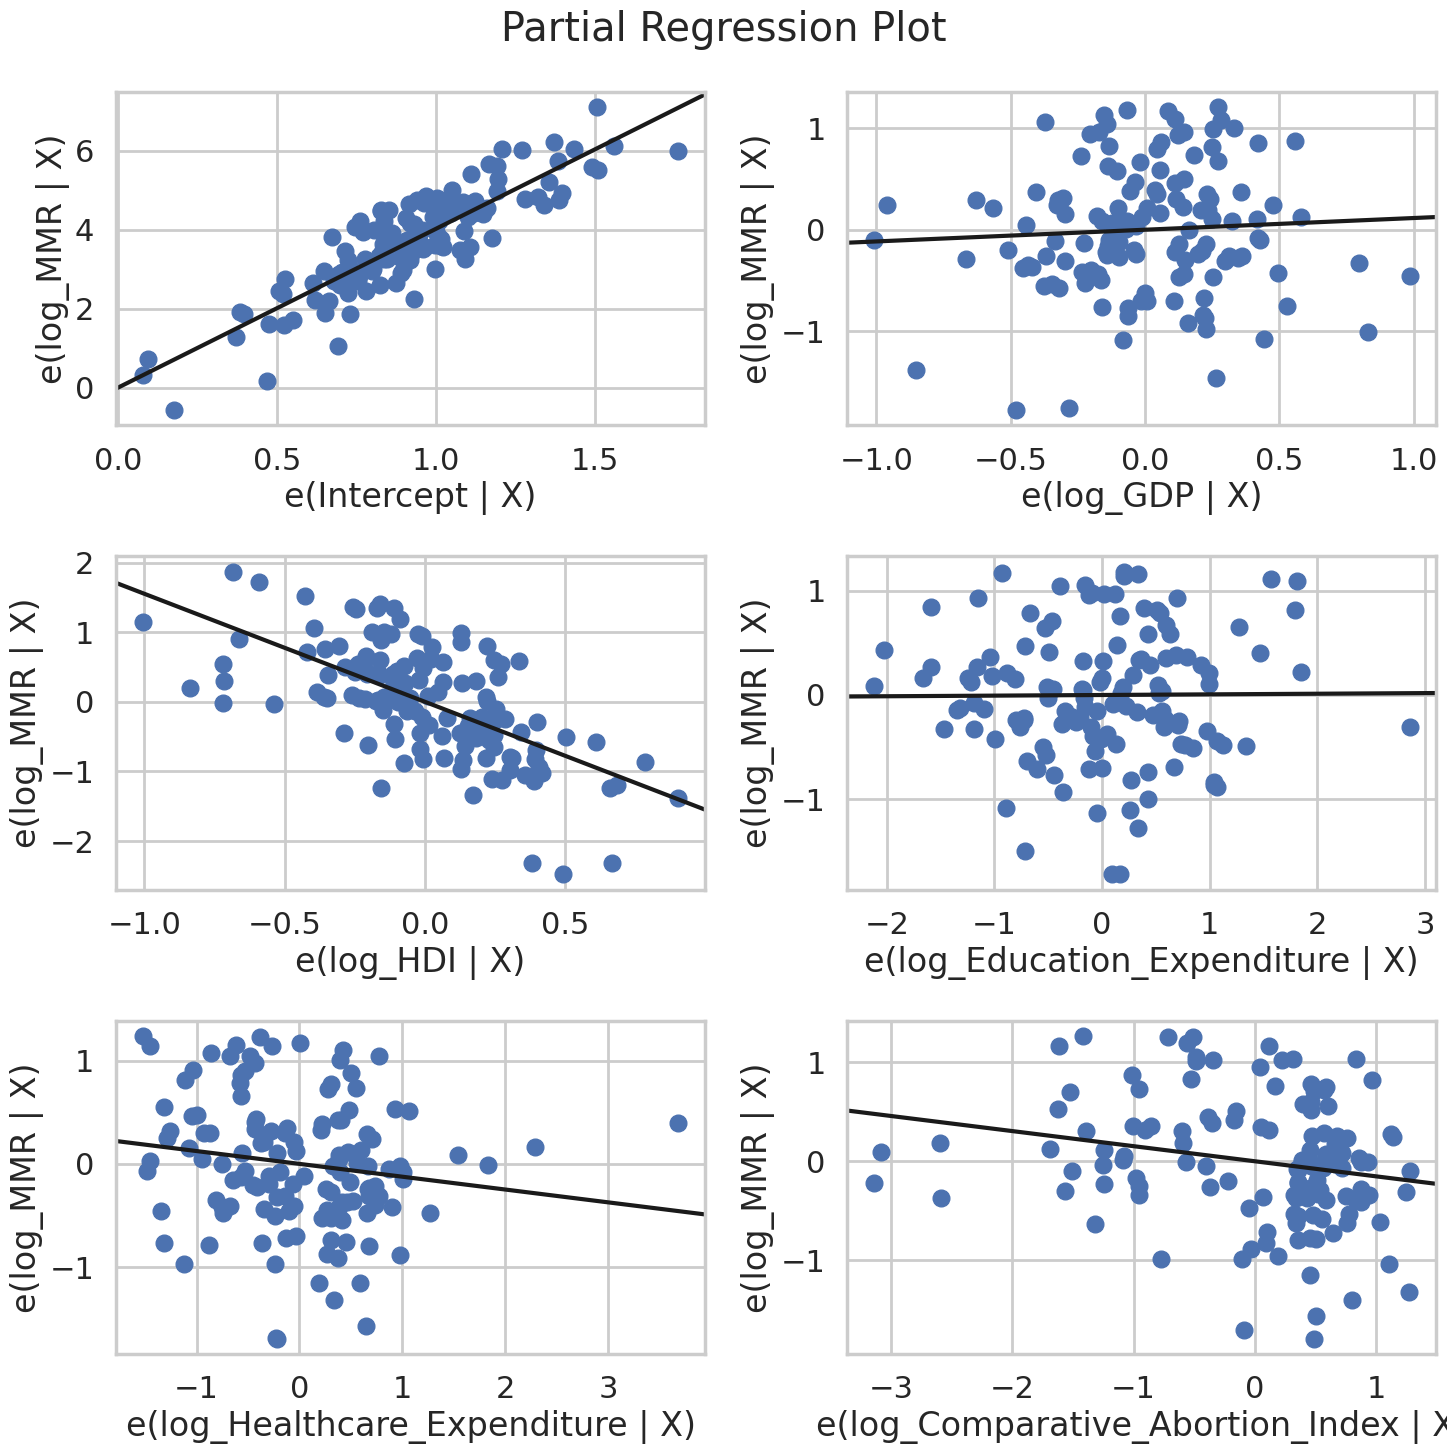

In [95]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.graphics.regressionplots import plot_partregress_grid

results = smf.ols('log_MMR ~ log_GDP + log_HDI + log_Education_Expenditure + log_Healthcare_Expenditure + log_Comparative_Abortion_Index', data=merged).fit()

# Create the figure
fig = plt.figure(figsize=(15, 15))

# Plot the partial regression plots
plot_partregress_grid(results, fig=fig)

# Show the plots
plt.tight_layout()
plt.show()

Lastly, I am plotting the coefficient values and their error bars. The bars that do not cross over zero are statistically significant.

/tmp/ipykernel_1908/1505685615.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(coef_df['varname'], rotation=45, ha='right', fontsize=10)


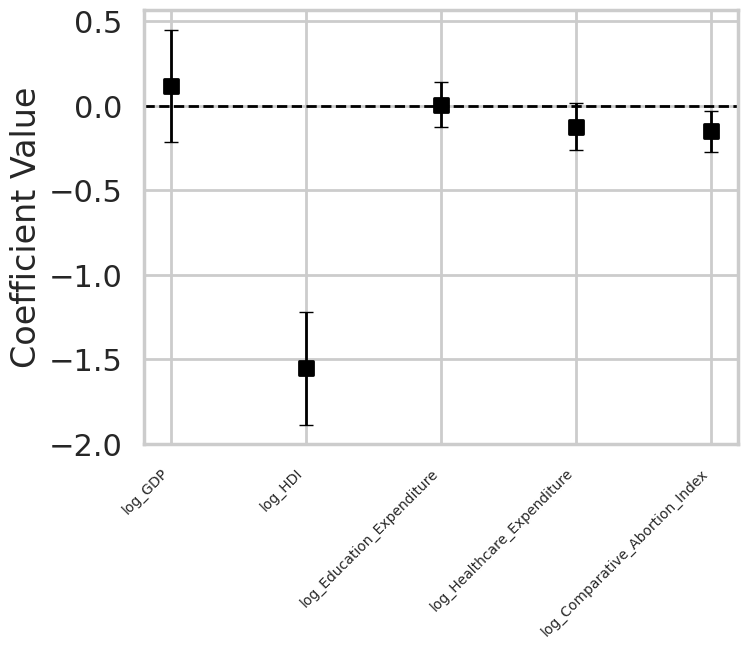

In [86]:
# Your OLS results data
coef_data = {
    'coef': [ 0.1151, -1.5522, 0.0061, -0.1241, -0.1524],
    'std_err': [ 0.170, 0.170, 0.067, 0.070, 0.062],
    'varname': ['log_GDP', 'log_HDI', 'log_Education_Expenditure', 'log_Healthcare_Expenditure', 'log_Comparative_Abortion_Index']
}

# Calculate error (error bars) from std_err
coef_df = pd.DataFrame(coef_data)
coef_df['err'] = coef_df['std_err'] * 1.96  # 95% CI for error bars (1.96*std_err)

# Plot
fig, ax = plt.subplots(figsize=(8, 7))

# Add error bars with vertical lines
ax.errorbar(coef_df['varname'], coef_df['coef'], yerr=coef_df['err'], fmt='none', 
            ecolor='black', elinewidth=2, capsize=5)

# Add scatter plot for coefficients
ax.scatter(coef_df['varname'], coef_df['coef'], color='black', s=100, marker='s')

# Add horizontal line at y=0
ax.axhline(y=0, linestyle='--', color='black', linewidth=2)

# Customize x-tick labels
ax.set_ylabel('Coefficient Value')
ax.set_xlabel('')
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels(coef_df['varname'], rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()